In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import absolute_import, division, print_function

import os
import sys
import glob
import argparse
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

from PIL import Image, ImageChops

import torch
from torchvision import transforms, datasets

import networks
from layers import disp_to_depth

# device = ("cuda" if torch.cuda.is_available else "cpu")
device = "cpu"

In [3]:
def test_simple(image_path, model_path, ext):
    """Function to predict for a single image or folder of images
    """
    print("-> Loading model from ", model_path)
    encoder_path = os.path.join(model_path, "encoder.pth")
    depth_decoder_path = os.path.join(model_path, "depth.pth")

    # LOADING PRETRAINED MODEL
    print("   Loading pretrained encoder")
    encoder = networks.ResnetEncoder(18, False)
    loaded_dict_enc = torch.load(encoder_path, map_location=device)

    # extract the height and width of image that this model was trained with
    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)
    encoder.to(device)
    encoder.eval()

    print("   Loading pretrained decoder")
    depth_decoder = networks.DepthDecoder(
        num_ch_enc=encoder.num_ch_enc, scales=range(4))

    loaded_dict = torch.load(depth_decoder_path, map_location=device)
    depth_decoder.load_state_dict(loaded_dict)

    depth_decoder.to(device)
    depth_decoder.eval()

    # FINDING INPUT IMAGES
    if os.path.isfile(image_path):
        # Only testing on a single image
        paths = [image_path]
        output_directory = os.path.dirname(image_path)
    elif os.path.isdir(image_path):
        # Searching folder for images
        paths = glob.glob(os.path.join(image_path, '*.{}'.format(ext)))
        output_directory = image_path
    else:
        raise Exception("Can not find image_path: {}".format(image_path))

    print("-> Predicting on {:d} test images".format(len(paths)))

    # PREDICTING ON EACH IMAGE IN TURN
    with torch.no_grad():
        for idx, image_path in enumerate(paths):

            if image_path.endswith("_disp.jpg"):
                # don't try to predict disparity for a disparity image!
                continue

            # Load image and preprocess
            input_image = pil.open(image_path).convert('RGB')
            original_width, original_height = input_image.size
            input_image = input_image.resize((feed_width, feed_height), pil.LANCZOS)
            input_image = transforms.ToTensor()(input_image).unsqueeze(0)

            # PREDICTION
            input_image = input_image.to(device)
            features = encoder(input_image)
            outputs = depth_decoder(features)

            disp = outputs[("disp", 0)]
            disp_resized = torch.nn.functional.interpolate(
                disp, (original_height, original_width), mode="bilinear", align_corners=False)

            # Saving numpy file
            output_name = os.path.splitext(os.path.basename(image_path))[0]
            name_dest_npy = os.path.join(output_directory, "{}_disp.npy".format(output_name))
            scaled_disp, _ = disp_to_depth(disp, 0.1, 100)
            np.save(name_dest_npy, scaled_disp.cpu().numpy())

            # Saving colormapped depth image
            disp_resized_np = disp_resized.squeeze().cpu().numpy()
            vmax = np.percentile(disp_resized_np, 95)
            normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
            mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
            colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
            im = pil.fromarray(colormapped_im)

            name_dest_im = os.path.join(output_directory, "{}_disp.jpeg".format(output_name))
            im.save(name_dest_im)

            print("   Processed {:d} of {:d} images - saved prediction to {}".format(
                idx + 1, len(paths), name_dest_im))

    print('-> Done!')

In [4]:
model = 'mono_model_nyu_04_lr.001_ds-4_CONT'
weights_idx = 4

img_paths = ['/home/cassava_media_arts/monodepth_simpletests/85_49_FL.jpg',
             '/home/cassava_media_arts/monodepth_simpletests/85_49_F.jpg',
             '/home/cassava_media_arts/monodepth_simpletests/85_49_FR.jpg',
             '/home/cassava_media_arts/monodepth_simpletests/85_49_BL.jpg',
             '/home/cassava_media_arts/monodepth_simpletests/85_49_B.jpg',
             '/home/cassava_media_arts/monodepth_simpletests/85_49_BR.jpg']

depth_paths = ['/home/cassava_media_arts/monodepth_simpletests/85_49_FL_disp.npy',
               '/home/cassava_media_arts/monodepth_simpletests/85_49_F_disp.npy',
               '/home/cassava_media_arts/monodepth_simpletests/85_49_FR_disp.npy',
               '/home/cassava_media_arts/monodepth_simpletests/85_49_BL_disp.npy',
               '/home/cassava_media_arts/monodepth_simpletests/85_49_B_disp.npy',
               '/home/cassava_media_arts/monodepth_simpletests/85_49_BR_disp.npy']

model_path = '/home/cassava_media_arts/tmp/' + model + '/models/weights_' + str(weights_idx)

In [5]:
1 / np.load(depth_paths[1])[0][0]

array([[0.14785816, 0.14768748, 0.14777406, ..., 0.14306977, 0.14342424,
        0.14316167],
       [0.14758782, 0.14747214, 0.14732032, ..., 0.1424292 , 0.14285888,
        0.14270347],
       [0.14753243, 0.14751141, 0.14756328, ..., 0.14247036, 0.14290074,
        0.14256966],
       ...,
       [0.12124179, 0.12114494, 0.12093028, ..., 0.1176629 , 0.11767447,
        0.1177356 ],
       [0.12103446, 0.1209501 , 0.12072498, ..., 0.11761384, 0.11764591,
        0.1176511 ],
       [0.12099358, 0.1210947 , 0.12100129, ..., 0.11803227, 0.11807615,
        0.11806831]], dtype=float32)

In [7]:
MIN_DEPTH = 1e-3
MAX_DEPTH = 100
focal_length = 882 / (1224/320)
depth_scale_factor = 1
depthmaps = []

for i in range(len(depth_paths)):
    test_simple(img_paths[i], model_path, 'jpg')
    disp = np.load(depth_paths[i])[0][0]
    
    depth = focal_length / disp
    depth *= depth_scale_factor
    depthmaps.append(depth)

-> Loading model from  /home/cassava_media_arts/tmp/mono_model_nyu_04_lr.001_ds-4_CONT/models/weights_4
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/cassava_media_arts/monodepth_simpletests/85_49_FL_disp.jpeg
-> Done!
-> Loading model from  /home/cassava_media_arts/tmp/mono_model_nyu_04_lr.001_ds-4_CONT/models/weights_4
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/cassava_media_arts/monodepth_simpletests/85_49_F_disp.jpeg
-> Done!
-> Loading model from  /home/cassava_media_arts/tmp/mono_model_nyu_04_lr.001_ds-4_CONT/models/weights_4
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/cassava_media_arts/monodepth_simpletests/85_49_FR_disp.jpeg
-> Done!
-> Loading model from  /home/cassava_media_a

In [8]:
depthmaps[0]

array([[33.052345, 33.004856, 33.017902, ..., 33.905834, 34.029778,
        33.962677],
       [33.004665, 32.96693 , 32.935013, ..., 33.737255, 33.88483 ,
        33.84211 ],
       [33.00427 , 32.989418, 32.98386 , ..., 33.747982, 33.89178 ,
        33.814648],
       ...,
       [32.398094, 32.41496 , 32.379086, ..., 26.209116, 26.222126,
        26.215242],
       [32.419636, 32.43504 , 32.382805, ..., 26.21447 , 26.221693,
        26.213987],
       [32.44154 , 32.44829 , 32.409115, ..., 26.20873 , 26.21386 ,
        26.198112]], dtype=float32)

In [9]:
import numpy as np
from pyquaternion import Quaternion

FL_quat = Quaternion(np.array([ 0.68316462, -0.68338771,  0.17581486, -0.18799863]))
F_quat = Quaternion(np.array([ 0.50745829, -0.49812866,  0.49496606, -0.49934369]))
FR_quat = Quaternion(np.array([-0.19470424,  0.17808752, -0.68312934,  0.68095909]))
BL_quat = Quaternion(np.array([-0.67797289,  0.6871698,   0.19201452, -0.1768143]))
B_quat = Quaternion(np.array([-0.49033062,  0.50741961,  0.50819262, -0.49379061]))
BR_quat = Quaternion(np.array([-0.17126042,  0.1897148,   0.68851343, -0.6786766]))

FL_trans = np.array([1.28400265, 0.31639086, 1.67877024]) #* (800/20)
F_trans = np.array([ 1.50612211, -0.03602647,  1.69421848]) #* (800/20)
FR_trans = np.array([ 1.27320628, -0.31664681,  1.68114556]) #* (800/20)
BL_trans = np.array([1.04338732, 0.31565584, 1.66400371]) #* (800/20)
B_trans = np.array([ 0.81558292, -0.00559198,  1.65395645]) #* (800/20)
BR_trans = np.array([ 1.04116266, -0.31121292,  1.66718288]) #* (800/20)

FL_rotmat = FL_quat.rotation_matrix
F_rotmat = F_quat.rotation_matrix
FR_rotmat = FR_quat.rotation_matrix
BL_rotmat = BL_quat.rotation_matrix
B_rotmat = B_quat.rotation_matrix
BR_rotmat = BR_quat.rotation_matrix

# B_rotmat[0][2] = -B_rotmat[0][2]
# B_rotmat[1][2] = -B_rotmat[1][2]
# B_rotmat[2][2] = -B_rotmat[2][2]

print("B Rotation Matrix: ", B_rotmat)

rotations = [FL_rotmat,
             F_rotmat,
             FR_rotmat,
             BL_rotmat,
             B_rotmat,
             BR_rotmat
            ]

translations = [FL_trans,
                F_trans,
                FR_trans,
                BL_trans,
                B_trans,
                BR_trans
               ]

B Rotation Matrix:  [[-0.00419018  0.03149288 -0.99949519]
 [ 0.99998743 -0.00262    -0.0042748 ]
 [-0.00275331 -0.99950054 -0.0314815 ]]


In [10]:
imscale = 1224/320

K = [np.array([[879.03824732/imscale, 0,                    613.17597314/imscale, 0],
               [0,                    879.03824732/imscale, 524.14407205/imscale, 0],
               [0,                    0,                    1,                    0],
               [0,                    0,                    0,                    1]], dtype=np.float32),
     np.array([[882.61644117/imscale, 0,                    621.63358525/imscale, 0],
               [0,                    882.61644117/imscale, 524.38397862/imscale, 0],
               [0,                    0,                    1,                    0],
               [0,                    0,                    0,                    1]], dtype=np.float32),
     np.array([[880.41134027/imscale, 0,                    618.9494972/imscale,  0],
               [0,                    880.41134027/imscale, 521.38918482/imscale, 0],
               [0,                    0,                    1,                    0],
               [0,                    0,                    0,                    1]], dtype=np.float32),
     np.array([[881.28264688/imscale, 0,                    612.29732111/imscale, 0],
               [0,                    881.28264688/imscale, 521.77447199/imscale, 0],
               [0,                    0,                    1,                    0],
               [0,                    0,                    0,                    1]], dtype=np.float32),
     np.array([[882.93018422/imscale, 0,                    616.45479905/imscale, 0],
               [0,                    882.93018422/imscale, 528.27123027/imscale, 0],
               [0,                    0,                    1,                    0],
               [0,                    0,                    0,                    1]], dtype=np.float32),
     np.array([[881.63835671/imscale, 0,                    607.66308183/imscale, 0],
               [0,                    881.63835671/imscale, 525.6185326/imscale,  0],
               [0,                    0,                    1,                    0],
               [0,                    0,                    0,                    1]], dtype=np.float32)
    ]

In [11]:
# def convert_depth_to_point_cloud(depthmaps, n):
#     width = 320
#     height = 256
    
#     f_x = K[n][0][0]
#     f_y = K[n][1][1]
#     c_x = K[n][0][2]
#     c_y = K[n][1][2]
    
#     θ_x = 2 * np.arctan(width/2/f_x)
#     θ_y = 2 * np.arctan(height/2/f_y)

#     α_x = (np.pi - θ_x)/2
#     α_y = (np.pi - θ_y)/2

#     point_cloud = []

#     k = 0
#     y_threshold = 1.5

#     for i in range(depthmaps[n].shape[0]):
#         for j in range(depthmaps[n].shape[1]):
#             if k % 2 == 0:
#                 γ_x = α_x + (j * θ_x) / width
#                 γ_y = α_y + (i * θ_y) / height
#                 z = depthmaps[n][i][j]
#                 x = z / np.tan(γ_x)
#                 y = z / np.tan(γ_y)
# #                 if y < y_threshold:
# #                     point_cloud.append([x, y, z, 1])
#                 point_cloud.append([x, y, z])
#             k += 1

#     point_cloud = np.array(point_cloud)
#     print("Point cloud shape: ", point_cloud.shape)
#     return point_cloud

In [12]:
def convert_depth_to_point_cloud(depthmaps, K, n):
    y_threshold = 1.5
    width = 320
    height = 256
    point_cloud = []
    
    f_x = K[n][0][0]
    f_y = K[n][1][1]
    c_x = K[n][0][2]
    c_y = K[n][1][2]

    k = 0
    for i in range(depthmaps[n].shape[0]): #vertical dimension
        for j in range(depthmaps[n].shape[1]): #horizontal dimension
            if k % 5 == 0:
                z = depthmaps[n][i][j]
                x = (j - c_x) * z / f_x
                y = (i - c_y) * z / f_y
#                 if y < y_threshold:
#                     point_cloud.append([x, y, z])
                point_cloud.append([x, y, z])
            k += 1

    point_cloud = np.array(point_cloud)
    print("Point cloud shape: ", point_cloud.shape)
    return point_cloud

In [16]:
global_point_cloud = []
# for i in range(len(depthmaps)):
for i in range(6):
    #Convert point cloud to world coordinates
    for point in convert_depth_to_point_cloud(depthmaps, K, i):
#         point[2] -= 20.0
#         point[2] *= 4.0
        point_world = np.dot(rotations[i], point) + translations[i]
        global_point_cloud.append(point_world)
global_point_cloud = np.array(global_point_cloud)
print("Global point cloud shape: ", global_point_cloud.shape)

Point cloud shape:  (16384, 3)
Point cloud shape:  (16384, 3)
Point cloud shape:  (16384, 3)
Point cloud shape:  (16384, 3)
Point cloud shape:  (16384, 3)
Point cloud shape:  (16384, 3)
Global point cloud shape:  (98304, 3)


In [17]:
def plot_axes(ax):
    p1 = [0, 0, 0]
    p2 = [1, 0, 0]
    p3 = [0, 0, 0]
    p4 = [0, 1, 0]
    p5 = [0, 0, 0]
    p6 = [0, 0, 1]

    p7_F = [0, 0, 1]
    p8_B = [1, 0, 1]

    xs = [p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]]
    ys = [p1[1], p2[1], p3[1], p4[1], p5[1], p6[1]]
    zs = [p1[2], p2[2], p3[2], p4[2], p5[2], p6[2]]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(xs[0:2], ys[0:2], zs[0:2], color = 'red', label = 'x-axis')
    ax.plot(xs[2:4], ys[2:4], zs[2:4], color = 'green', label = 'y-axis')
    ax.plot(xs[4:6], ys[4:6], zs[4:6], color = 'blue', label = 'z-axis')

<IPython.core.display.Javascript object>


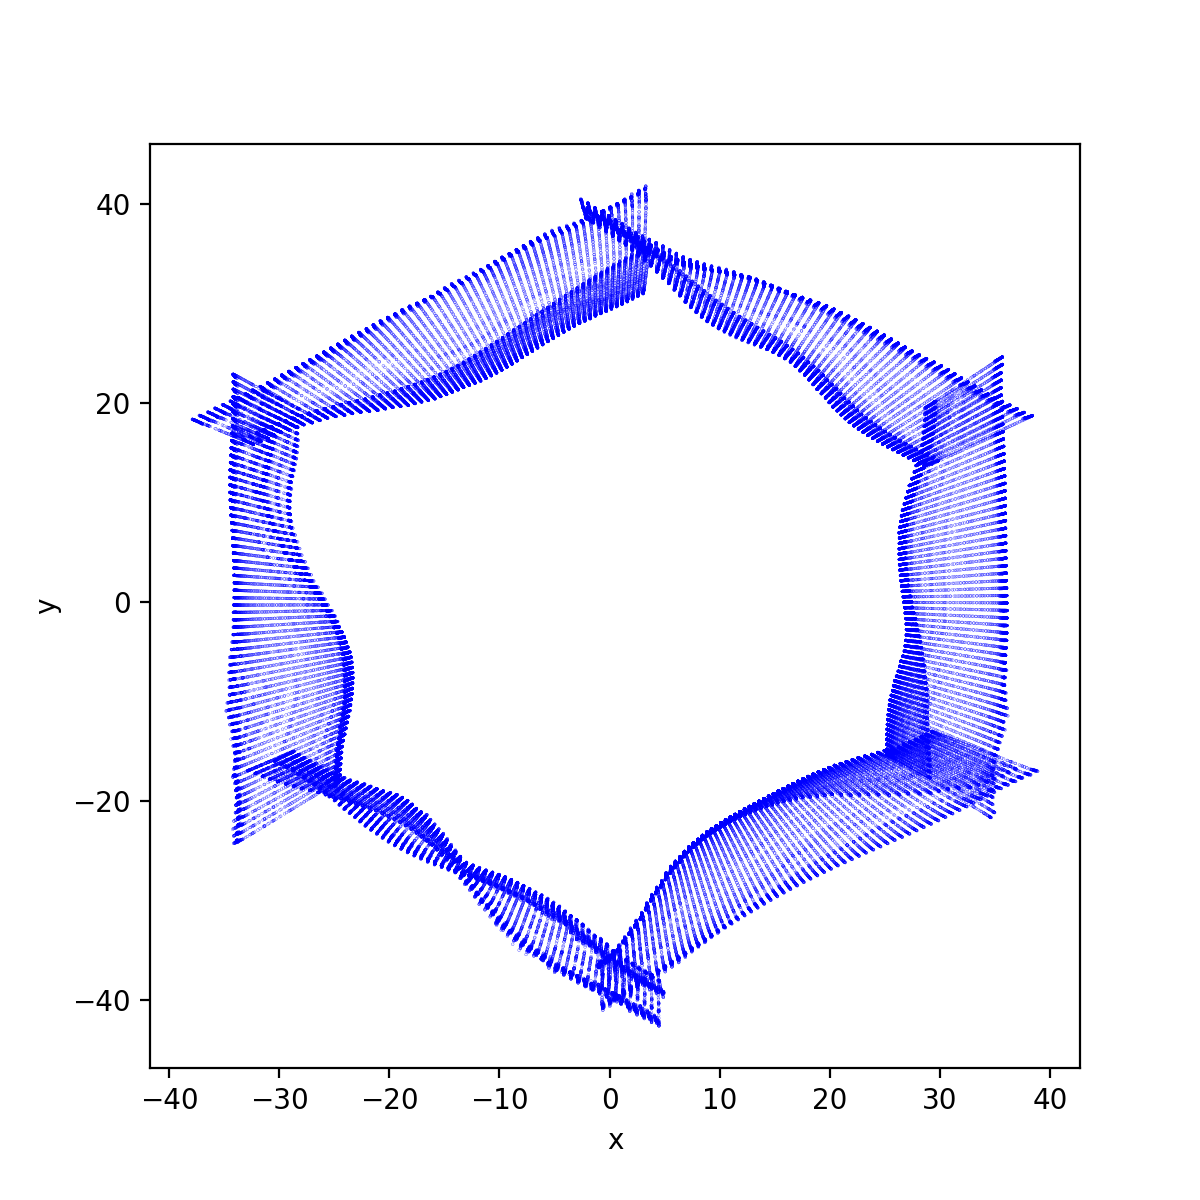

In [18]:
xs = global_point_cloud[:, 0]
ys = global_point_cloud[:, 1]
zs = global_point_cloud[:, 2]
size = [0.01]*len(xs)

################
###### 2D ######
################
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('x')
ax.set_ylabel('y')
# plt.scatter(ys, zs, cmap=cm.coolwarm, s=size)
plt.scatter(xs, ys, color='blue', s=size, label='FRONT')

################
###### 3D ######
################
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.scatter(xs, ys, zs, cmap=cm.coolwarm, s=size)
# plot_axes(ax)

In [769]:
# k = [[160,0,0],
#      [0,128,0],
#      [0,0,1]
#     ]

# def convert_cam_to_world(point):
#     k = [[160,0,0],
#      [0,128,0],
#      [0,0,1]
#     ]
#     width = 320
#     height = 256
    
#     f_x = k[0][0]
#     f_y = k[1][1]
#     c_x = k[0][2]
#     c_y = k[1][2]
    
#     θ_x = 2 * np.arctan(width/2/f_x)
#     θ_y = 2 * np.arctan(height/2/f_y)

#     α_x = (np.pi - θ_x)/2
#     α_y = (np.pi - θ_y)/2

#     γ_x = α_x + (160 * θ_x) / width
#     γ_y = α_y + (128 * θ_y) / height
#     z = point[2]
#     x = z / np.tan(γ_x)
#     y = z / np.tan(γ_y)
#     return (x, y, z)

# test = [0, 0, 1]
# convert_cam_to_world(test)